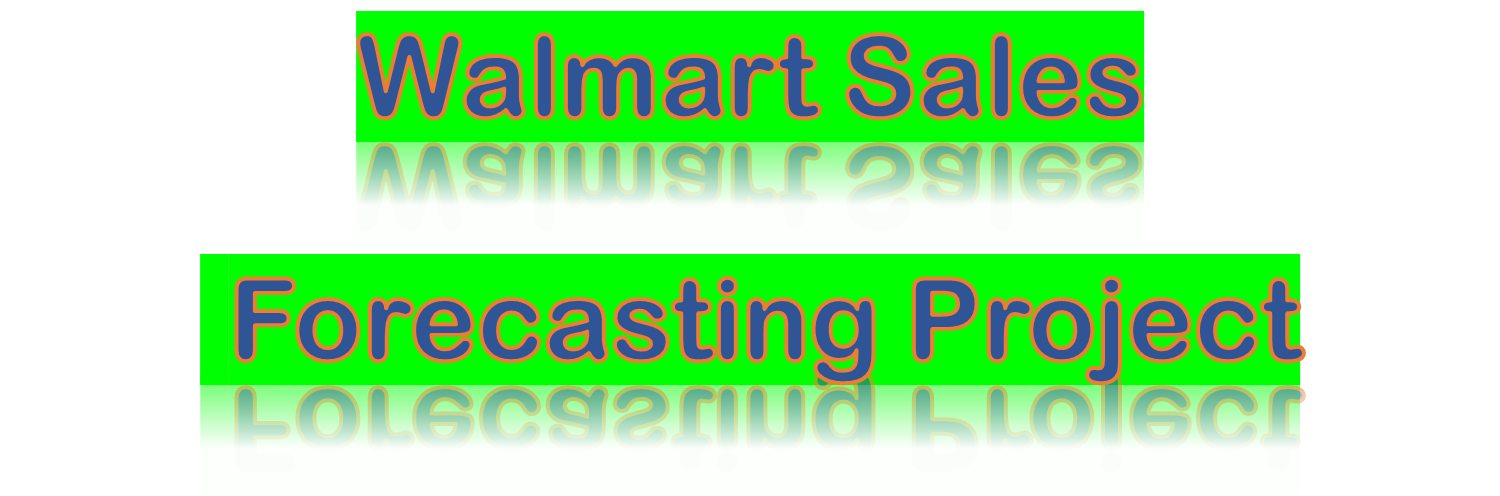

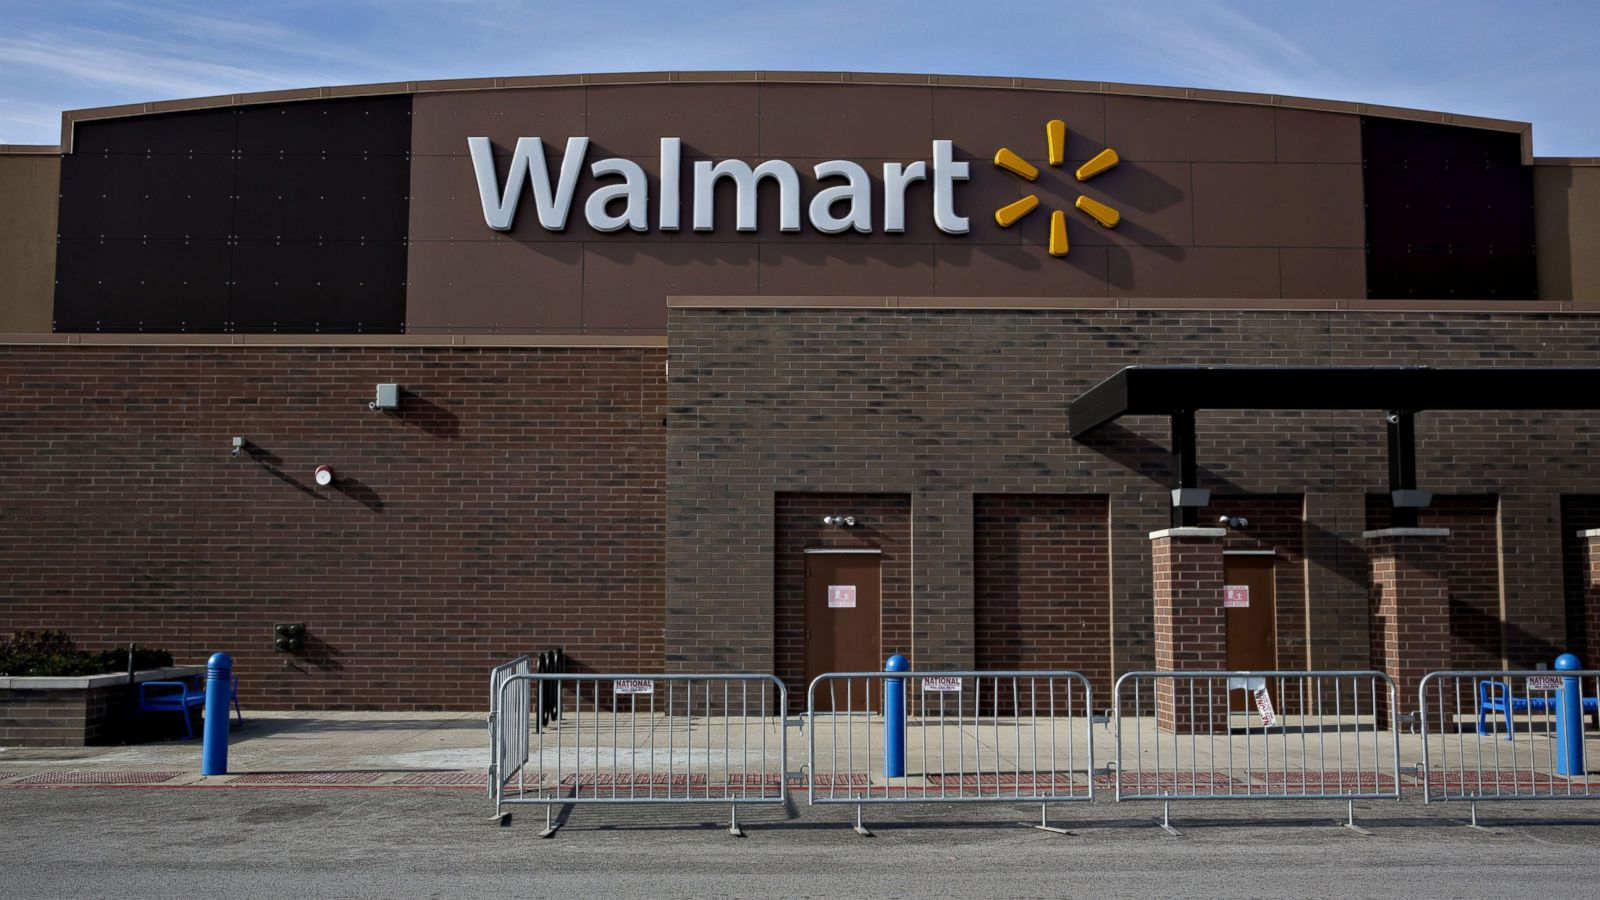

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import calendar
from datetime import timedelta

# import statsmodels.api as smimport 
import statsmodels.tsa.api as smtimport 
import statsmodels.formula.api as smf
import statsmodels.api as sm 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima
import itertools
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")
import ast
import pickle

# pip install plotly ipywidgets pandas
# !pip install pmdarima
# pip install tqdm

# Reading or Importing 'Walmart' Dataset

In [2]:
walmart = pd.read_csv('Walmart.csv',parse_dates=['Date'], dayfirst=True, skipinitialspace=True)

In [3]:
walmart.head()

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

# Exploratory Data Analysis

###  Minimum Date and Maximum Date

In [4]:
print('Min Date in Data is - {}'.format(walmart['Date'].min()))
print('Max Date in Data is - {}'.format(walmart['Date'].max()))

Min Date in Data is - 2010-02-05 00:00:00
Max Date in Data is - 2012-10-26 00:00:00


###  Shape of ths dataset

In [5]:
print('No of rows :',walmart.shape[0])
print('No of columns :',walmart.shape[1])

No of rows : 6435
No of columns : 8


### Columns of the dataset

In [6]:
for col in walmart.columns: print(col)

Store
Date
Weekly_Sales
Holiday_Flag
Temperature
Fuel_Price
CPI
Unemployment


### Datatypes of the columns

In [7]:
walmart.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

### Null values in dataset

In [8]:
print('Total null values in the dataset are :',walmart.isnull().sum().sum())
pd.DataFrame(walmart.isnull().sum())

Total null values in the dataset are : 0


0
Store         0
Date          0
Weekly_Sales  0
Holiday_Flag  0
Temperature   0
Fuel_Price    0
CPI           0
Unemployment  0

### Duplicate records in dataset

In [9]:
print('Total duplicates :',walmart.duplicated().sum())

Total duplicates : 0


### Total number of stores in dataset

In [10]:
no_of_stores = walmart['Store'].unique()
print(no_of_stores)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


45 stores data is available in walmart dataset 

In [11]:
pd.DataFrame(walmart['Store'].value_counts()).sort_index()

Store
1     143
2     143
3     143
4     143
5     143
6     143
7     143
8     143
9     143
10    143
11    143
12    143
13    143
14    143
15    143
16    143
17    143
18    143
19    143
20    143
21    143
22    143
23    143
24    143
25    143
26    143
27    143
28    143
29    143
30    143
31    143
32    143
33    143
34    143
35    143
36    143
37    143
38    143
39    143
40    143
41    143
42    143
43    143
44    143
45    143

Each store has equal amount of 143 records so dataset is well balanced.


### Outliers Checking

In [12]:
walmart[walmart["Weekly_Sales"]<=0]

Empty DataFrame
Columns: [Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment]
Index: []

There is no any store has weekly sales less than or equal to 0.

## Pairwise correlation of the columns

In [13]:
walmart.corr()

Store  Weekly_Sales  Holiday_Flag  Temperature  \
Store         1.000000e+00     -0.335332 -4.386841e-16    -0.022659   
Weekly_Sales -3.353320e-01      1.000000  3.689097e-02    -0.063810   
Holiday_Flag -4.386841e-16      0.036891  1.000000e+00    -0.155091   
Temperature  -2.265908e-02     -0.063810 -1.550913e-01     1.000000   
Fuel_Price    6.002295e-02      0.009464 -7.834652e-02     0.144982   
CPI          -2.094919e-01     -0.072634 -2.162091e-03     0.176888   
Unemployment  2.235313e-01     -0.106176  1.096028e-02     0.101158   

              Fuel_Price       CPI  Unemployment  
Store           0.060023 -0.209492      0.223531  
Weekly_Sales    0.009464 -0.072634     -0.106176  
Holiday_Flag   -0.078347 -0.002162      0.010960  
Temperature     0.144982  0.176888      0.101158  
Fuel_Price      1.000000 -0.170642     -0.034684  
CPI            -0.170642  1.000000     -0.302020  
Unemployment   -0.034684 -0.302020      1.000000

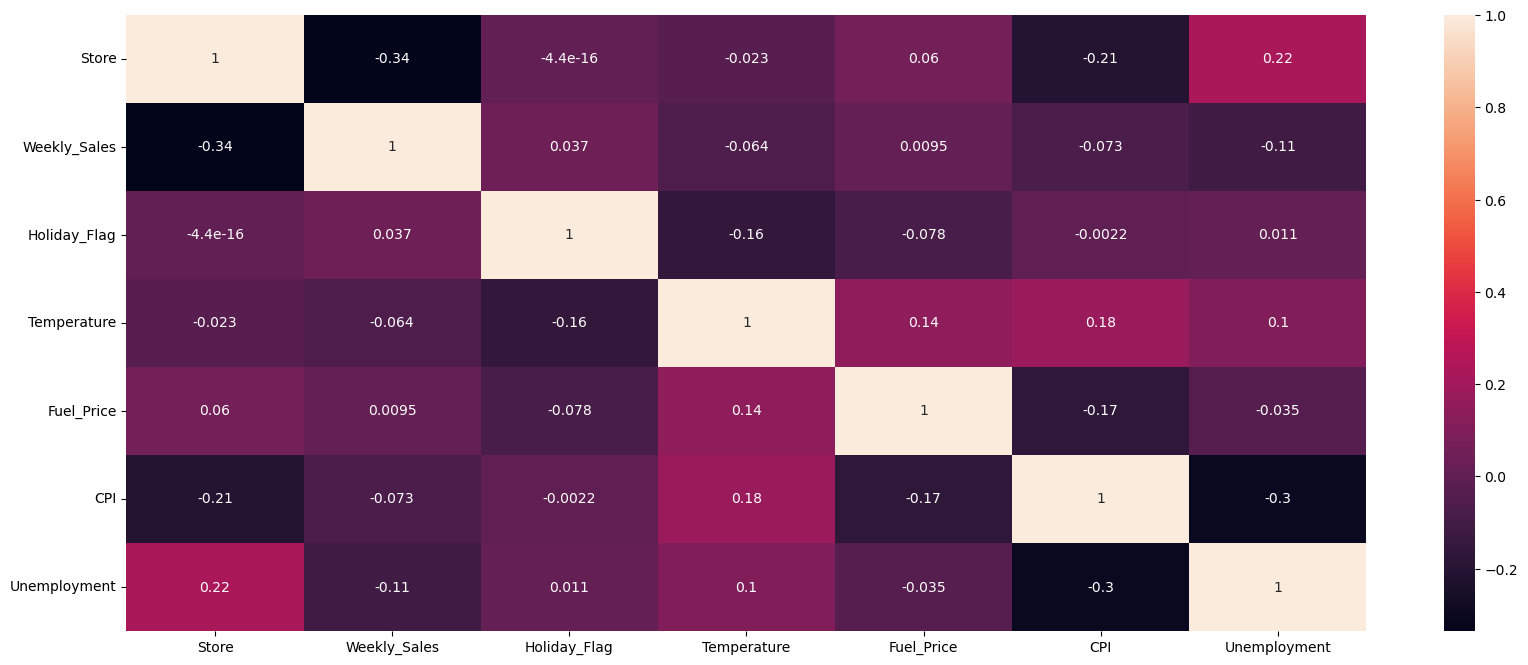

In [14]:
plt.figure(figsize=(20,8))
sns.heatmap(walmart.corr(),annot=True)
plt.show()

Temperature, Fuel price, CPI and Unemployment are very weakly coorelated with the weekly sales.

Holiday_Flag will be considered for the further analysis as the sales in the holiday weeks are higher than in the non-holiday weeks.

# Top 10 Store with highet weekly sales

In [15]:
# Summing weekly sales for getting top stores 
top_sales_stores = pd.DataFrame(walmart.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).reset_index())
top_sales_stores.head(10)

Store  Weekly_Sales
0     20  3.013978e+08
1      4  2.995440e+08
2     14  2.889999e+08
3     13  2.865177e+08
4      2  2.753824e+08
5     10  2.716177e+08
6     27  2.538559e+08
7      6  2.237561e+08
8      1  2.224028e+08
9     39  2.074455e+08

Top weekly sales Store no : 20, 4, 14, 13, 2, 10, 27, 6, 1, 39

# Visualizing the each store by weekly sales

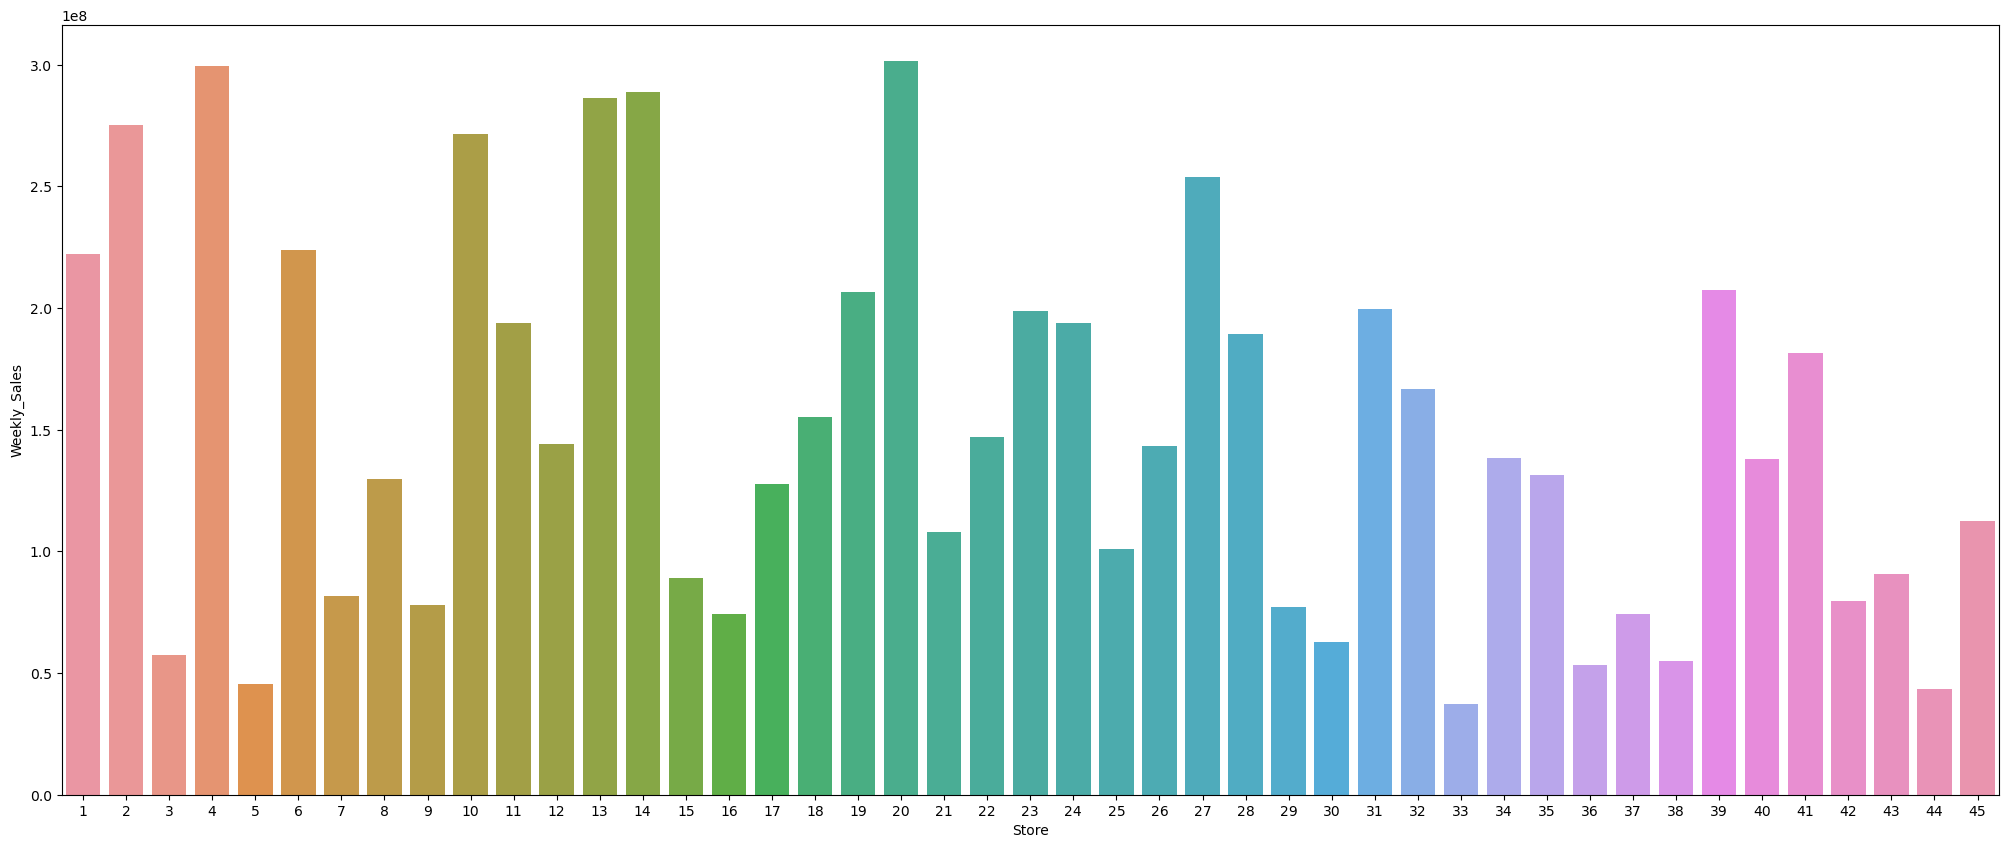

In [16]:
# Store comparison for total weekly sales 
plt.figure(figsize=(25,10))
sns.barplot(x='Store',y='Weekly_Sales',data=top_sales_stores)
plt.show()

This is a side-by-side comparision visualisation for total sales of each store per year.
As seen, there is a lot of variance in sales amount of every store.

# Analyzing the weekly sales with holiday sales and non-holiday sales

In [17]:
no_holiday_sales = pd.DataFrame(walmart[walmart['Holiday_Flag'] == 0].groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).reset_index())
no_holiday_sales.head(10)

Store  Weekly_Sales
0     20  2.789074e+08
1      4  2.771129e+08
2     14  2.677941e+08
3     13  2.653873e+08
4      2  2.545898e+08
5     10  2.504802e+08
6     27  2.349329e+08
7      6  2.069471e+08
8      1  2.057453e+08
9     39  1.919343e+08

In [18]:
holiday_sales = pd.DataFrame(walmart[walmart['Holiday_Flag'] == 1].groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).reset_index())
holiday_sales.head(10)

Store  Weekly_Sales
0     20   22490350.81
1      4   22431026.24
2     14   21205829.98
3     10   21137559.49
4     13   21130438.06
5      2   20792669.00
6     27   18922992.78
7      6   16809079.27
8      1   16657476.56
9     19   15770467.34

In [19]:
# Merge 'no_holiday_sales' with 'top_sales_stores'
top_sales_stores = top_sales_stores.merge(no_holiday_sales[['Store', 'Weekly_Sales']], on='Store', how='left')

# Merge 'holiday_sales' with 'top_sales_stores'
top_sales_stores = top_sales_stores.merge(holiday_sales[['Store', 'Weekly_Sales']], on='Store', how='left')

# Rename the columns
top_sales_stores = top_sales_stores.rename(columns={'Weekly_Sales_x': 'Weekly_Sales', 'Weekly_Sales_y': 'Weekly_Sales_no_holiday','Weekly_Sales':'Weekly_Sales_holiday'})
top_sales_stores.head()

Store  Weekly_Sales  Weekly_Sales_no_holiday  Weekly_Sales_holiday
0     20  3.013978e+08             2.789074e+08           22490350.81
1      4  2.995440e+08             2.771129e+08           22431026.24
2     14  2.889999e+08             2.677941e+08           21205829.98
3     13  2.865177e+08             2.653873e+08           21130438.06
4      2  2.753824e+08             2.545898e+08           20792669.00

In [20]:
top_sales_stores = top_sales_stores.sort_values('Store')

fig = go.Figure(data=[
    go.Bar(name='Weekly Sales (No Holiday)', x=top_sales_stores['Store'], y=top_sales_stores['Weekly_Sales_no_holiday']),
    go.Bar(name='Weekly Sales (Holiday)', x=top_sales_stores['Store'], y=top_sales_stores['Weekly_Sales_holiday']),
])

fig.update_layout(
    title='Weekly Sales Comparison of Each Store',
    xaxis_title='Store',
    yaxis_title='Weekly Sales',
    barmode='stack',
    bargap=0.2,
    bargroupgap=0.1,
    showlegend=True

)

# Adjust x-axis ticktext and tickvals
fig.update_xaxes(ticktext=top_sales_stores['Store'], tickvals=top_sales_stores.Store)

fig.show()

Based on the provided analysis, we can conclude that the presence of holidays does not seem to have a significant impact on weekly sales when compared to weeks with no holidays.

# Statistical description

In [21]:
walmart.describe()

Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000      3.879000  
25%     131.735000      6.891000  
50%     182.616521      7.874000  
75%     212.743293      8.622000  
max     227.232807     14.313000

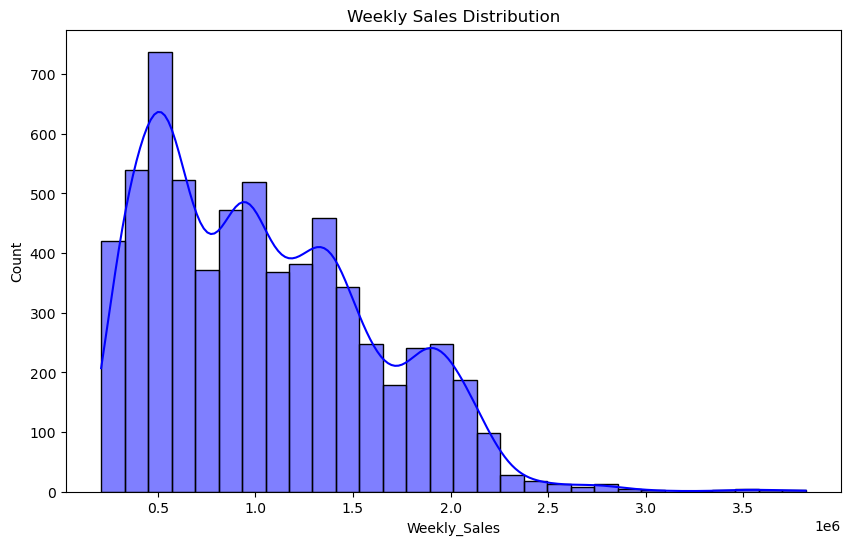

In [22]:
plt.figure(figsize=(10, 6))
walmart["Weekly_Sales"]=walmart.Weekly_Sales

sns.histplot(walmart.Weekly_Sales, kde=True, bins=30, color = 'blue')
plt.title('Weekly Sales Distribution')
plt.show()

# Adding Date Information to Walmart Data

In [23]:
walmart["Day"] = walmart.Date.dt.day
walmart["Month"] = walmart.Date.dt.month
walmart["Year"]  = walmart.Date.dt.year
walmart['Month'] = walmart['Month'].apply(lambda x: calendar.month_abbr[x])

Segregating the Date column in Day, Month & Year columns

In [24]:
walmart = walmart.set_index('Date')

In [25]:
walmart = walmart.sort_index()
walmart.head()

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-05     10    2193048.75             0        54.34       2.962   
2010-02-05     37     536006.73             0        45.97       2.572   
2010-02-05     17     789036.02             0        23.11       2.666   
2010-02-05     30     465108.52             0        39.05       2.572   

                   CPI  Unemployment  Day Month  Year  
Date                                                   
2010-02-05  211.096358         8.106    5   Feb  2010  
2010-02-05  126.442065         9.765    5   Feb  2010  
2010-02-05  209.852966         8.554    5   Feb  2010  
2010-02-05  126.442065         6.548    5   Feb  2010  
2010-02-05  210.752605         8.324    5   Feb  2010

In [26]:
fig = px.scatter(walmart,y='Weekly_Sales',color='Holiday_Flag')
fig.show()

# Dash App with Date Subplots

In [63]:
# Create the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='store-dropdown',
        options=[{'label': f"Store {store}", 'value': store} for store in sorted(walmart['Store'].unique())],
        value=sorted(walmart['Store'].unique())[0],
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='features-date-subplots')
])

# Define the callback to update the graphs based on the selected store
@app.callback(
    Output('features-date-subplots', 'figure'),
    [Input('store-dropdown', 'value')]
)
def update_graph(selected_store):
    # Filter the data based on the selected store
    filtered_df = walmart[walmart['Store'] == selected_store]

    # Create subplots with 2 rows and 2 columns
    fig = sp.make_subplots(rows=2, cols=3,
                           subplot_titles=[
                               f"Weekly_Sales over the years for Store {selected_store}",
                               f"Fuel_Price over the years for Store {selected_store}",
                               f"Temperature over the years for Store {selected_store}",
                               f"Unemployment over the years for Store {selected_store}",
                               f"CPI over the years for Store {selected_store}"])
    # Weekly_Sales
    fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df['Weekly_Sales'], mode='lines'), row=1, col=1)
    # Fuel_Price
    fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df['Fuel_Price'], mode='lines',), row=1, col=2)
    # Temperature
    fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df['Temperature'], mode='lines'), row=1, col=3)
   # Unemployment 
    fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df['Unemployment'], mode='lines'), row=2, col=1)
   # CPI 
    fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df['CPI'], mode='lines'), row=2, col=2)
   # Update subplot layout
    fig.update_layout(title=f"Date Subplots for Store {selected_store}",
                      height=800,  # Increase the height of the graph
                      width=1700)  # Increase the width of the graph
   # Update subplots' x-axis and y-axis titles
    fig.update_yaxes(title_text="Weekly_Sales", row=1, col=1)
    fig.update_yaxes(title_text="Fuel_Price", row=1, col=2)
    fig.update_yaxes(title_text="Temperature", row=1, col=3)
    fig.update_yaxes(title_text="Unemployment", row=2, col=1)
    fig.update_yaxes(title_text="CPI", row=2, col=2)
    fig.update_xaxes(title_text="Date",dtick='M6', row=1, col=1)
    fig.update_xaxes(title_text="Date",dtick='M6', row=1, col=2)
    fig.update_xaxes(title_text="Date",dtick='M6', row=1, col=3)
    fig.update_xaxes(title_text="Date",dtick='M6', row=2, col=1)
    fig.update_xaxes(title_text="Date",dtick='M6', row=2, col=2)
    # Add range slider for date to each subplot
    for row in range(1, 3):
        for col in range(1, 4):
            fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness=0.04, row=row, col=col)
    return fig

# Use the interact function to update the plots based on the selected controls
# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8050)
    

### [View the full app showcasing the relationship between Date with other features for each store.](http://127.0.0.1:8050/ 'Click here')

Walmart typically starts its Christmas sales in early November, and they run through the end of December. The best deals are usually found in the weeks leading up to Christmas, and on the day after Christmas.

Here are some of the specific dates to keep an eye on:

Early November: Walmart starts rolling out its Christmas merchandise in early November. This is a good time to start shopping for early bird deals.
Black Friday: Walmart's Black Friday sale is one of the best times to find Christmas deals. The sale starts on Thanksgiving Day and runs through the weekend.
Cyber Monday: Walmart's Cyber Monday sale is another great opportunity to find Christmas deals. The sale is held on the Monday after Thanksgiving.
December 26: The day after Christmas is a great time to find Christmas clearance deals at Walmart. Items are typically marked down by 50% or more.
December 31: Walmart's New Year's Eve sale is a good time to find last-minute Christmas deals. The sale starts on December 31 and runs through the end of the day.

The specific dates of Walmart's Christmas sales may vary from year to year.

In [28]:
# For ease of reference, lets seperate the weeks which had holidays in a particular week

special_Holiday = pd.DataFrame(walmart[(walmart['Holiday_Flag']==1)].index.unique())
special_Holiday.columns = ['Special Holidays (Yearly)']
special_Holiday

Special Holidays (Yearly)
0                2010-02-12
1                2010-09-10
2                2010-11-26
3                2010-12-31
4                2011-02-11
5                2011-09-09
6                2011-11-25
7                2011-12-30
8                2012-02-10
9                2012-09-07

# Dash App with Weekly Sales subplots

In [29]:
# Create the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='store-dropdown',
        options=[{'label': f"Store {store}", 'value': store} for store in sorted(walmart['Store'].unique())],
        value=sorted(walmart['Store'].unique())[0],
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='weekly-sales-subplots')
])

# Define the callback to update the graphs based on the selected store
@app.callback(
    Output('weekly-sales-subplots', 'figure'),
    [Input('store-dropdown', 'value')]
)
def update_graph(selected_store):
    # Filter the data based on the selected store
    filtered_df = walmart[walmart['Store'] == selected_store]

    # Create subplots with 2 rows and 2 columns
    fig = sp.make_subplots(rows=2, cols=2,
                           subplot_titles=[
                               f"Weekly Sales vs Fuel_Price for Store {selected_store}",
                               f"Weekly Sales vs Temperature for Store {selected_store}",
                               f"Weekly Sales vs Unemployment for Store {selected_store}",
                               f"Weekly Sales vs CPI for Store {selected_store}"])
    # Fuel_Price vs Weekly_Sales
    fig.add_trace(go.Scatter(x=filtered_df['Fuel_Price'], y=filtered_df['Weekly_Sales'], mode='markers'), row=1, col=1)
    # Temperature vs Weekly_Sales
    fig.add_trace(go.Scatter(x=filtered_df['Temperature'], y=filtered_df['Weekly_Sales'], mode='markers'), row=1, col=2)
   # Unemployment vs Weekly_Sales
    fig.add_trace(go.Scatter(x=filtered_df['Unemployment'], y=filtered_df['Weekly_Sales'], mode='markers'), row=2, col=1)
   # CPI vs Weekly_Sales
    fig.add_trace(go.Scatter(x=filtered_df['CPI'], y=filtered_df['Weekly_Sales'], mode='markers'), row=2, col=2)
   # Update subplot layout
    fig.update_layout(title=f"Weekly Sales Subplots for Store {selected_store}",
                      height=800,  # Increase the height of the graph
                      width=1600)  # Increase the width of the graph
   # Update subplots' x-axis and y-axis titles
    fig.update_xaxes(title_text="Fuel_Price", row=1, col=1)
    fig.update_xaxes(title_text="Temperature", row=1, col=2)
    fig.update_xaxes(title_text="Unemployment", row=2, col=1)
    fig.update_xaxes(title_text="CPI", row=2, col=2)
    fig.update_yaxes(title_text="Weekly Sales", row=1, col=1)
    fig.update_yaxes(title_text="Weekly Sales", row=1, col=2)
    fig.update_yaxes(title_text="Weekly Sales", row=2, col=1)
    fig.update_yaxes(title_text="Weekly Sales", row=2, col=2)
    return fig
# Use the interact function to update the plots based on the selected controls
# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

### [View the full app visualizing the relationship between weekly sales and other features for each store.](http://127.0.0.1:8051/ 'Click here')

# Dash App with Seasonal Decomposition 

In [30]:
# Create the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='store-dropdown',
        options=[{'label': f"Store {store}", 'value': store} for store in sorted(walmart['Store'].unique())],
        value=walmart['Store'].unique()[0],
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='seasonal-decomposition-trend'),
    dcc.Graph(id='seasonal-decomposition-seasonal'),
    dcc.Graph(id='seasonal-decomposition-residual')
])

# Define the callback to update the graphs based on the selected store
@app.callback(
    [Output('seasonal-decomposition-trend', 'figure'),
     Output('seasonal-decomposition-seasonal', 'figure'),
     Output('seasonal-decomposition-residual', 'figure')],
    [Input('store-dropdown', 'value')]
)
def update_graph(selected_store):
    # Selecting the data for the selected store
    store_data = walmart[walmart['Store'] == selected_store]
    
    # Perform seasonal decomposition for the selected store
    seasonal_decomp_result = seasonal_decompose(store_data['Weekly_Sales'], period=12)

   # Create the seasonal decomposition trend plot
    trend_fig = go.Figure()
    trend_fig.add_trace(go.Scatter(x=seasonal_decomp_result.trend.index, y=seasonal_decomp_result.trend, name='Trend'))
    trend_fig.update_layout(title=f"Trend for Store {selected_store}",height=250,width=800,
                            xaxis_title='Date',
                            yaxis_title='Trend Value')

   # Create the seasonal decomposition seasonal plot
    seasonal_fig = go.Figure()
    seasonal_fig.add_trace(go.Scatter(x=seasonal_decomp_result.seasonal.index, y=seasonal_decomp_result.seasonal, name='Seasonal'))
    seasonal_fig.update_layout(title=f"Seasonal Component for Store {selected_store}",height=250,width=800,
                               xaxis_title='Date',
                               yaxis_title='Seasonal Component')

   # Create the seasonal decomposition residual plot
    residual_fig = go.Figure()
    residual_fig.add_trace(go.Scatter(x=seasonal_decomp_result.resid.index, y=seasonal_decomp_result.resid, name='Residual'))
    residual_fig.update_layout(title=f"Residual for Store {selected_store}",height=250,width=800,
                               xaxis_title='Date',
                               yaxis_title='Residual Value')
    
    return trend_fig, seasonal_fig, residual_fig

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline',debug=True, port=8052,)

### [View the full app showcasing seasonal decomposition components for each store.](http://127.0.0.1:8052/ 'Click here')

# Augmented Dickey-Fuller test to check the stationarity for each store

In [31]:
def dftest(timeseries, store_id):
    dftest_result = ts.adfuller(timeseries)
    dfoutput = pd.Series(dftest_result[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Observations Used'])
    for key, value in dftest_result[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    # Adding a column to identify the Store ID
    dfoutput['Store ID'] = store_id

    return dfoutput

# Create an empty DataFrame to store the results for each store
adf_results = pd.DataFrame(columns=['Store ID', 'Test Statistic', 'p-value', 'Lags Used', 'Observations Used',
                                    'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'])

# Iterate through each store and perform ADF test
for store_id in walmart['Store'].unique():
    store_sales = walmart[walmart['Store'] == store_id]['Weekly_Sales']
    adf_result = dftest(store_sales, store_id)
    adf_results = adf_results.append(adf_result, ignore_index=True)

# Converting 'Store ID' column to integer data type
adf_results['Store ID'] = adf_results['Store ID'].astype(int)
adf_results.sort_values(by='Store ID', inplace=True)

def cond_formatting(x):
    if x < 0.05:
        return 'background-color: lightgreen'
    else:
        return 'background-color: red'
    
#display DataFrame with conditional formatting applied    
adf_results.style.applymap(cond_formatting,subset=['p-value'])

After running the Augmented Dickey-Fuller test to check the stationarity of the walmart data for each store.

Green values are represention staionary data and red are showing non-staionary data for that particular store.

The p-value is very small for the stores :[1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,37,39,40,41,45]. These results provide strong evidence against the null hypothesis of non-stationarity. Therefore, we reject the null hypothesis in favor of the alternative hypothesis that the time series is stationary.

And for the Stores : [14,30,36,38,42,43,44] contains non-stationary data.

# Visualizing Rolling Mean and Standard Deviation for each store

In [32]:
# Create the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='store-dropdown',
        options=[{'label': f"Store {store}", 'value': store} for store in sorted(walmart['Store'].unique())],
        value=sorted(walmart['Store'].unique())[0],
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='Rolling Mean and Standard Deviation')
])

# Define the callback to update the graphs based on the selected store
@app.callback(
    Output('Rolling Mean and Standard Deviation', 'figure'),
    [Input('store-dropdown', 'value')]
)
def update_graph(selected_store):
    # Filter the data based on the selected store
    filtered_df = walmart[walmart['Store'] == selected_store]
    sales_data = filtered_df['Weekly_Sales']
    rolmean = sales_data.rolling(window=4).mean()
    rolstd = sales_data.rolling(window=4).std()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_df.index, y=sales_data, mode='lines', name='Original'))
    fig.add_trace(go.Scatter(x=filtered_df.index, y=rolmean,mode='lines',name='Rolling Mean'))
    fig.add_trace(go.Scatter(x=filtered_df.index, y=rolstd,mode='lines', name='Rolling Std'))
    fig.update_layout(title='Rolling Mean and Standard Deviation',
                       xaxis_title='Year',
                     showlegend=True)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8053)

### [View the full app showcasing Rolling Mean and Standard Deviation for each store.](http://127.0.0.1:8053/ 'Click here')

# Plotting ACF & PACF  to identify 'p' & 'q' values

Enter Store No. : 1


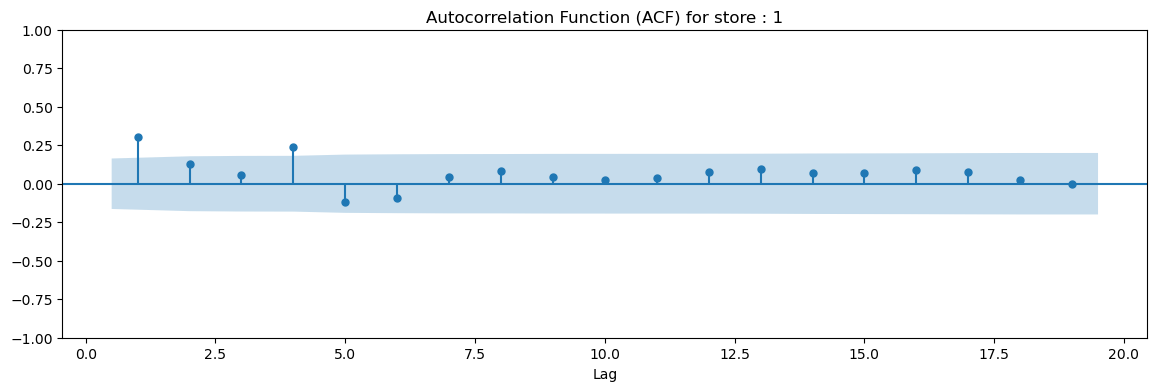

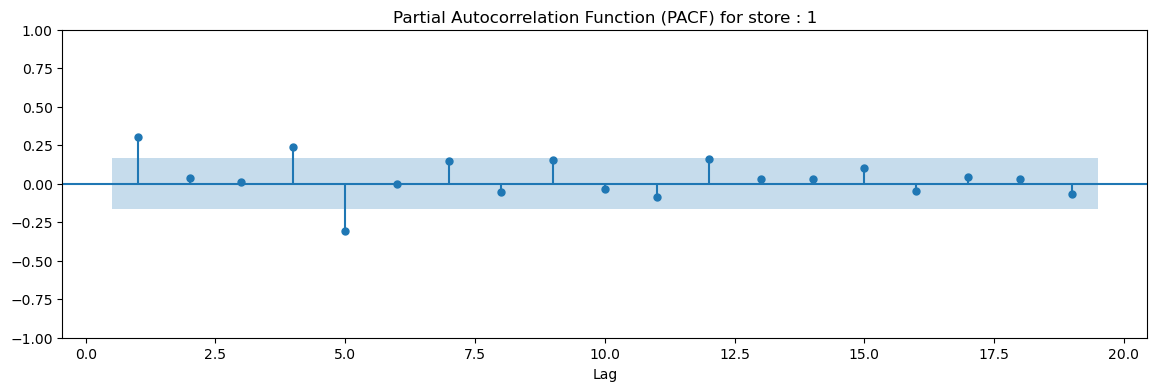

In [33]:
store_number = int(input('Enter Store No. : '))

store_weekly_sales = walmart[walmart['Store']==store_number]

plt.rcParams['figure.figsize'] = [14, 4]

# Plot ACF
fig = sm.tsa.graphics.plot_acf(store_weekly_sales['Weekly_Sales'], lags=range(1,20), alpha=0.05,
                               title=f'Autocorrelation Function (ACF) for store : {store_number}')
plt.xlabel('Lag')
plt.show()

# Plot PACF
fig = sm.tsa.graphics.plot_pacf(store_weekly_sales['Weekly_Sales'], lags=range(1,20), alpha=0.05,
                                title = (f'Partial Autocorrelation Function (PACF) for store : {store_number}'))
plt.xlabel('Lag')
plt.show()

We are unable to decide the value of p and q so we will use auto arima which is having the least aic value

# Performing Auto-ARIMA model to get best values of order('p','d','q') and seasonal order('P','D','Q',m)

In [34]:
# #Build a loop to fit the model and get the predictions for each store (45 store in total)
# results_df = pd.DataFrame(columns=['Store', 'Order', 'Seasonal_Order'])

# # Get the total number of stores for the progress bar
# total_stores = 45  # Assuming the store IDs range from 1 to 45

# arima_models = {}  # Create a dictionary to store the SARIMA models


# for i in tqdm(range(1, total_stores + 1), desc='Stores Progress'):
#     S=walmart[walmart["Store"]==i]
#     S.groupby('Date').size()
#     S_df=S.drop(['Store'],axis='columns')
#     S_df['IsHoliday']= S_df["Holiday_Flag"].astype(int)
#     S_train=S_df.groupby('Date').agg(
#         Weekly_Sales=('Weekly_Sales','sum'),
#         IsHoliday=('IsHoliday','min'),
#         Temperature=('Temperature',np.mean),
#         Fuel_Price=("Fuel_Price",np.mean),
#         CPI=('CPI',np.mean),
#         Unemployment=('Unemployment',np.mean))
    
#     #Exogenous variables
#     exog_data = S_train[['Temperature', 'CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']]
#     endog_data = S_train['Weekly_Sales']
    
    
#     #Fit the model
#     model = auto_arima(y=endog_data, 
#                        x=exog_data,
#                        D=1,
#                        m=52,
#                        seasonal=True, 
#                        Trend = 'ct', 
#                        test='adf',
#                        parallel=True, stepwise = True,
#                        n_jobs=-1, transform='auto')

#     #Store the model in the dictionary with the store number as the key
#     arima_models[f'arima_model{i}'] = model
    
#     # Record the suggested model and hyperparameters in the DataFrame
#     row = {
#         'Store': i,
#         'Order': model.order,
#         'Seasonal_Order': model.seasonal_order,
        
#     }
#     results_df = results_df.append(row, ignore_index=True)

In [35]:
# results_df

### Saving the Auto-ARIMA models using pickle

In [36]:
# with open('arima_models.pkl', 'wb') as f:
#     pickle.dump(arima_models, f)

### Exporting Auto-ARIMA results to CSV file

In [37]:
# results_df.to_csv('SARIMA orders.csv',index=False)

### Loading the Auto-ARIMA models using pickle

In [38]:
# with open('arima_models.pkl', 'rb') as f:
#     arima_models = pickle.load(f)

### Importing Auto-ARIMA results in results_df dataframe

In [39]:
results_df = pd.read_csv('SARIMA orders.csv')

In [40]:
results_df

Store      Order Seasonal_Order
0       1  (1, 0, 1)  (2, 1, 0, 52)
1       2  (1, 0, 3)  (2, 1, 0, 52)
2       3  (0, 1, 1)  (0, 1, 1, 52)
3       4  (1, 1, 0)  (0, 1, 0, 52)
4       5  (1, 0, 1)  (0, 1, 1, 52)
5       6  (1, 0, 1)  (0, 1, 2, 52)
6       7  (0, 1, 1)  (0, 1, 0, 52)
7       8  (3, 0, 1)  (0, 1, 2, 52)
8       9  (2, 1, 0)  (0, 1, 0, 52)
9      10  (1, 0, 0)  (1, 1, 0, 52)
10     11  (1, 0, 1)  (2, 1, 0, 52)
11     12  (0, 1, 1)  (0, 1, 1, 52)
12     13  (2, 0, 3)  (2, 1, 0, 52)
13     14  (0, 1, 2)  (0, 1, 1, 52)
14     15  (2, 0, 0)  (2, 1, 0, 52)
15     16  (1, 1, 0)  (0, 1, 1, 52)
16     17  (0, 0, 0)  (1, 1, 1, 52)
17     18  (2, 0, 2)  (0, 1, 2, 52)
18     19  (1, 0, 1)  (0, 1, 0, 52)
19     20  (0, 0, 0)  (0, 1, 1, 52)
20     21  (0, 0, 0)  (0, 1, 0, 52)
21     22  (0, 0, 0)  (1, 1, 0, 52)
22     23  (0, 1, 1)  (0, 1, 1, 52)
23     24  (0, 0, 0)  (2, 1, 0, 52)
24     25  (1, 0, 0)  (0, 1, 2, 52)
25     26  (1, 1, 0)  (2, 1, 0, 52)
26     27  (1, 0, 0)  (1, 1, 0, 52)
27     28  (0, 0, 1)  (0, 1, 0, 52)
28     29  (0, 0, 0)  (0, 1, 2, 52)
29     30  (1, 1, 0)  (0, 1, 1, 52)
30     31  (2, 1, 0)  (2, 1, 0, 52)
31     32  (0, 0, 0)  (0, 1, 0, 52)
32     33  (1, 1, 0)  (2, 1, 0, 52)
33     34  (2, 1, 0)  (0, 1, 0, 52)
34     35  (0, 1, 1)  (0, 1, 1, 52)
35     36  (0, 1, 0)  (0, 1, 0, 52)
36     37  (0, 0, 1)  (0, 1, 0, 52)
37     38  (1, 1, 0)  (0, 1, 0, 52)
38     39  (2, 1, 0)  (2, 1, 0, 52)
39     40  (1, 1, 0)  (0, 1, 1, 52)
40     41  (0, 0, 0)  (0, 1, 0, 52)
41     42  (1, 1, 0)  (2, 1, 0, 52)
42     43  (0, 1, 0)  (0, 1, 0, 52)
43     44  (1, 0, 0)  (0, 1, 2, 52)
44     45  (1, 0, 1)  (0, 1, 1, 52)

# Creating SARIMAX models for 45 stores and forecasting Weekly_Sales of existing sales to check model accuracy 

In [41]:
#MAPE function
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
# total_stores = 45
# fc_weekly_sales = []
# sarimax_models = {}  # Create a dictionary to store the SARIMA models

# for i in tqdm(range(1, total_stores + 1), desc='Stores Progress'):
#     S = walmart[walmart["Store"] == i]
#     S_df = S.drop(['Store'], axis='columns')
#     S_df['IsHoliday'] = S_df["Holiday_Flag"].astype(int)
#     S_train = S_df.groupby('Date').agg(
#         Weekly_Sales=('Weekly_Sales', 'sum'),
#         IsHoliday=('IsHoliday', 'min'),
#         Temperature=('Temperature', np.mean),
#         Fuel_Price=("Fuel_Price", np.mean),
#         CPI=('CPI', np.mean),
#         Unemployment=('Unemployment', np.mean)
#     )
    
#     R = results_df[results_df["Store"] == i]     # Calling resuts_df file for sarima orders
#     Order = ast.literal_eval(tuple(R.Order)[0])
#     Seasonal_Order = ast.literal_eval(tuple(R.Seasonal_Order)[0])

#     # Defining target variable as endog_data and exogenous variables as exog_data.
#     exog_data = S_train[['Temperature', 'CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']]
#     endog_data = S_train['Weekly_Sales']

#     # Fit the SARIMAX model with exogenous variables
#     sarimax = sm.tsa.statespace.SARIMAX(endog=endog_data, exog=exog_data,
#                                     trend='ct',
#                                     order=Order,  # Non-seasonal order (p, d, q)
#                                     seasonal_order=Seasonal_Order).fit()
    
#     # Store the model in the dictionary with the store number as the key
#     sarimax_models[f'sarimax{i}'] = sarimax
    
#     # Forecasting from the 53rd index and ending at the 143rd index of the DataFrame
#     forecast_exog = exog_data.iloc[53:143 + 1]  # Include both start and end indices
#     fc_store_weekly_sales = pd.DataFrame(index=S_train.index[53:143 + 1])
#     fc_store_weekly_sales['Date'] = endog_data.index[53:143+1]
#     fc_store_weekly_sales['Store'] = i
#     fc_store_weekly_sales['Weekly_Sales'] = endog_data.iloc[53:143+1]
    
#     # Initialize an empty array to store forecasted values
#     forecasted_values = []

#     # Iterate through each row in forecast_exog and perform forecasting
#     for idx, exog_row in forecast_exog.iterrows():
#         forecasted_value = sarimax.get_prediction(start=idx, end=idx, exog=exog_row).predicted_mean
#         forecasted_values.append(forecasted_value[0])  # Append the forecasted value to the list

#     fc_store_weekly_sales['Forecasted_Sales'] = forecasted_values
#     fc_store_weekly_sales['MAPE'] = MAPE(fc_store_weekly_sales['Weekly_Sales'], fc_store_weekly_sales['Forecasted_Sales'])

#     fc_weekly_sales.append(fc_store_weekly_sales)

# # Concatenate all the store forecasts into a single DataFrame
# forecast_existing_weekly_sales = pd.concat(fc_weekly_sales, ignore_index=True)

In [43]:
# forecast_existing_weekly_sales

### Saving the SARIMAX models using pickle

In [44]:
# with open('sarimax_models.pkl', 'wb') as f:
#     pickle.dump(sarimax_models, f)

### Exporting Forecast of existing sales results to CSV file

In [45]:
# forecast_existing_weekly_sales.to_csv('forecast_existing_weekly_sales.csv',index=False)

### Loading the SARIMAX models using pickle

In [46]:
with open('sarimax_models.pkl', 'rb') as f:
    sarimax_models = pickle.load(f)

### Importing results for forecast of existing sales 

In [47]:
forecast_existing_weekly_sales = pd.read_csv('forecast_existing_weekly_sales.csv')

In [48]:
# Print the resulting DataFrame
forecast_existing_weekly_sales

Date  Store  Weekly_Sales  Forecasted_Sales      MAPE
0     2011-02-11      1    1649614.93      1.674735e+06  2.993534
1     2011-02-18      1    1686842.78      1.660113e+06  2.993534
2     2011-02-25      1    1456800.28      1.484747e+06  2.993534
3     2011-03-04      1    1636263.41      1.606500e+06  2.993534
4     2011-03-11      1    1553191.63      1.486872e+06  2.993534
...          ...    ...           ...               ...       ...
4045  2012-09-28     45     713173.95      6.962922e+05  4.186975
4046  2012-10-05     45     733455.07      7.826228e+05  4.186975
4047  2012-10-12     45     734464.36      7.055535e+05  4.186975
4048  2012-10-19     45     718125.53      7.683265e+05  4.186975
4049  2012-10-26     45     760281.43      7.749803e+05  4.186975

[4050 rows x 5 columns]

In [49]:
forecast_existing_weekly_sales['MAPE'].unique()

array([2.99353434, 2.80144994, 4.80725678, 4.02730453, 3.77864507,
       3.0100379 , 4.52218568, 2.6672813 , 4.02213678, 3.49027449,
       3.69431525, 3.94954322, 3.10797727, 6.42910098, 4.90081037,
       5.18980533, 3.28459067, 6.18162334, 3.81696583, 3.71776553,
       4.10198913, 4.18672804, 7.05727173, 4.26597548, 3.94472726,
       3.89378486, 4.92405628, 5.0407676 , 4.79353291, 3.30947453,
       2.81323945, 2.5261648 , 4.4893027 , 3.83163165, 6.21419279,
       5.01181415, 2.28926344, 4.66447595, 3.91769245, 5.53497444,
       3.44752187, 3.42775517, 3.97957231, 2.8092384 , 4.1869755 ])

In [50]:
sarimax_models.keys()

dict_keys(['sarimax1', 'sarimax2', 'sarimax3', 'sarimax4', 'sarimax5', 'sarimax6', 'sarimax7', 'sarimax8', 'sarimax9', 'sarimax10', 'sarimax11', 'sarimax12', 'sarimax13', 'sarimax14', 'sarimax15', 'sarimax16', 'sarimax17', 'sarimax18', 'sarimax19', 'sarimax20', 'sarimax21', 'sarimax22', 'sarimax23', 'sarimax24', 'sarimax25', 'sarimax26', 'sarimax27', 'sarimax28', 'sarimax29', 'sarimax30', 'sarimax31', 'sarimax32', 'sarimax33', 'sarimax34', 'sarimax35', 'sarimax36', 'sarimax37', 'sarimax38', 'sarimax39', 'sarimax40', 'sarimax41', 'sarimax42', 'sarimax43', 'sarimax44', 'sarimax45'])

## Plotting the diagnostics plot of given sarimax model (Ex : model = sarimax36 of store 36)

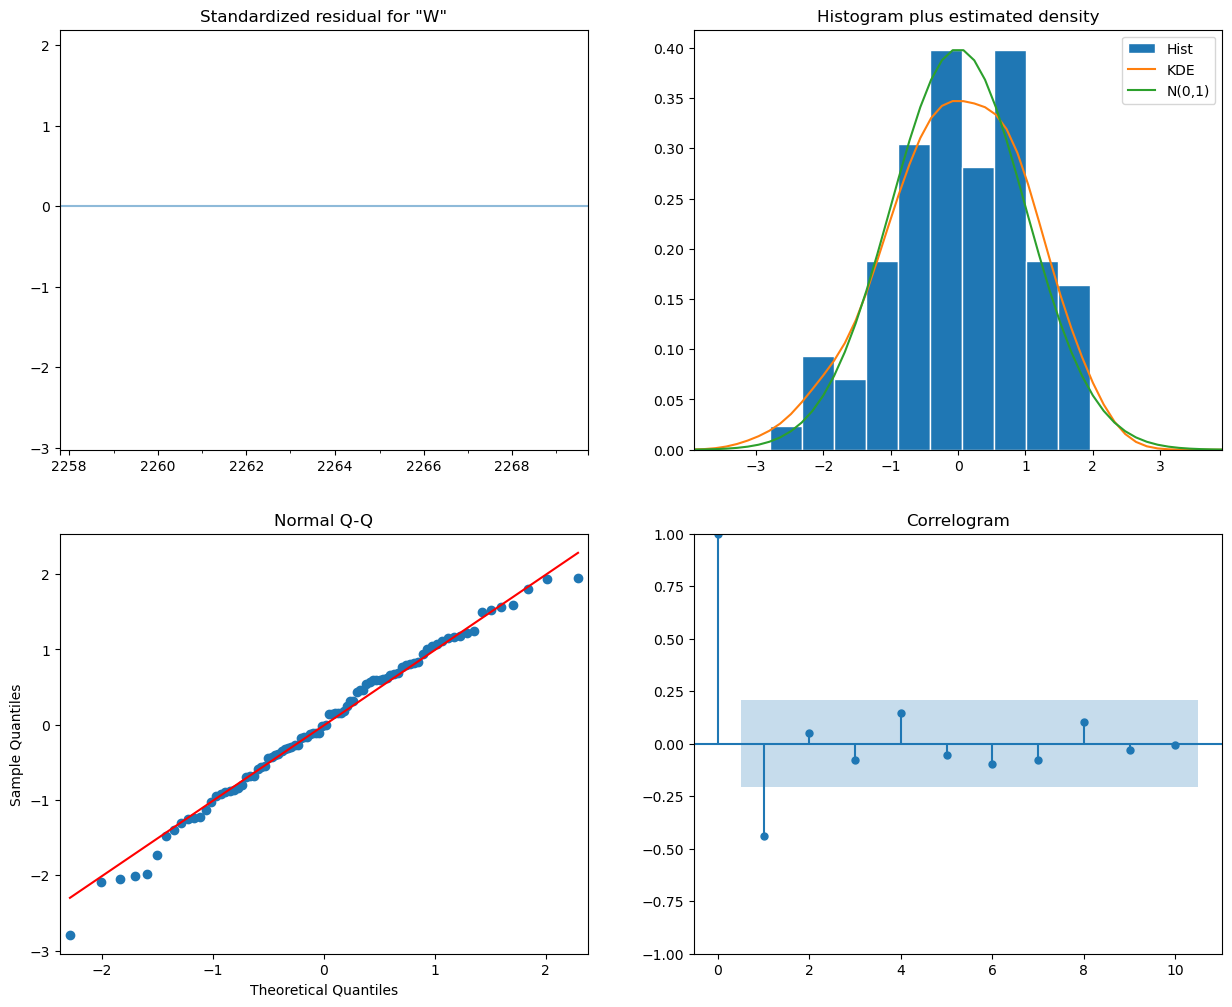

In [51]:
# Access the SARIMA model for store 
sar = sarimax_models['sarimax36']

# Plot diagnostics for the SARIMA model of store 2
sar.plot_diagnostics(figsize=(15, 12))
plt.show()

### Residuals plots with density

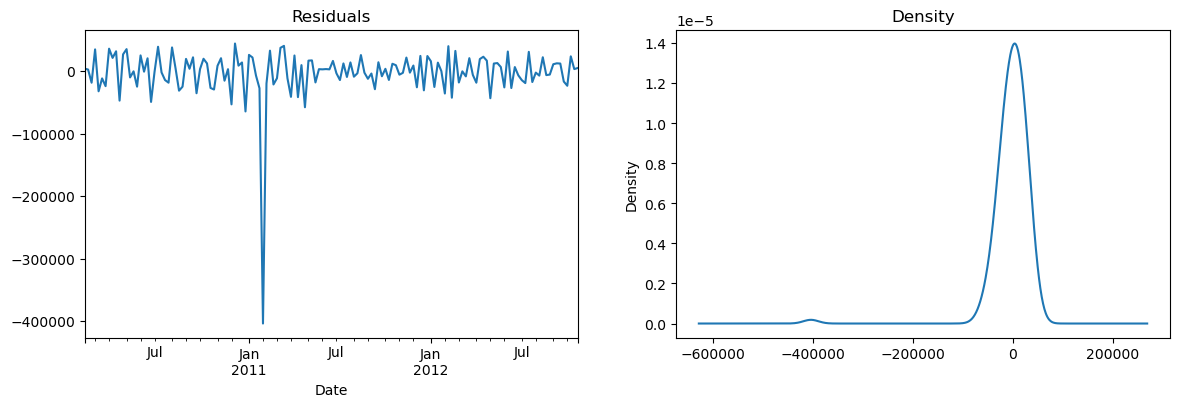

In [52]:
residuals = sar.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

### Plotting ACF-PACF plot for residuals

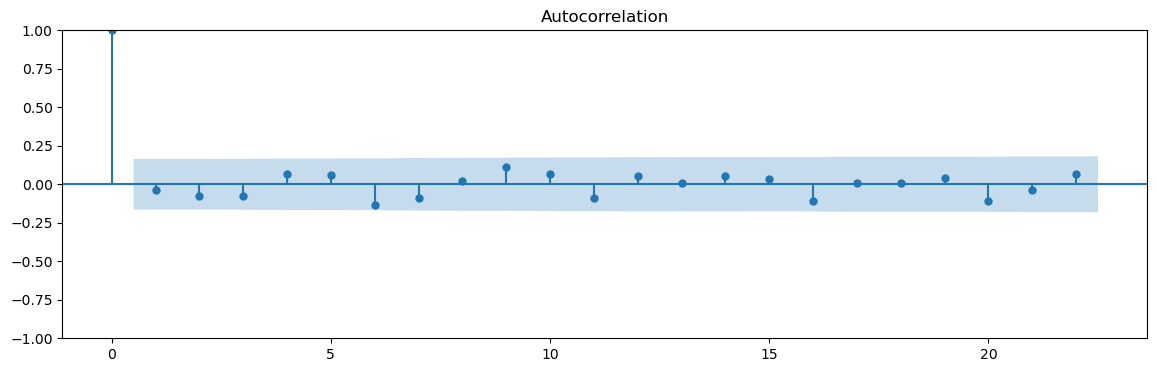

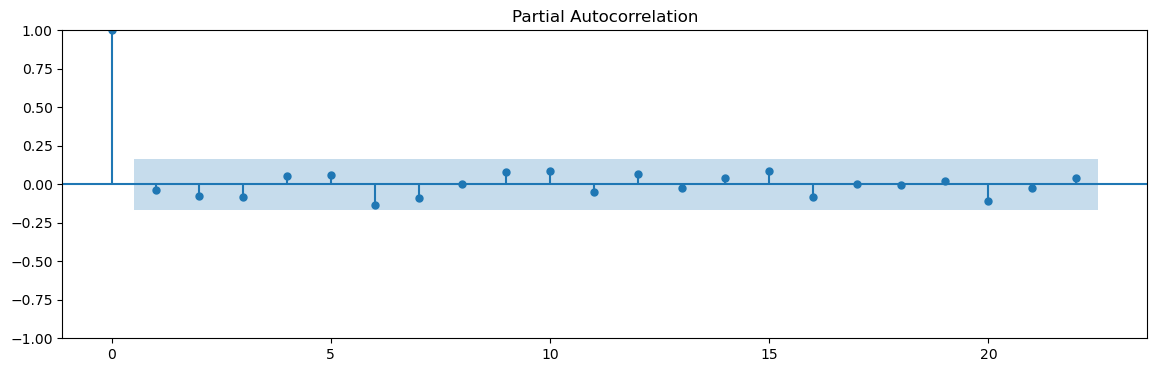

In [53]:
acf_res = sm.tsa.graphics.plot_acf(residuals)
pacf_res = sm.tsa.graphics.plot_pacf(residuals)

# Dashboard to Visualize original weekly sales & forecasted weekly sales for existing data

In [54]:
# Create a Dash app
app = dash.Dash(__name__)

# Assuming you have already generated the final_fc_weekly_sales DataFrame

# Get unique store IDs
unique_stores = forecast_existing_weekly_sales['Store'].unique()

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='store-dropdown',
        options=[{'label': str(store_id), 'value': store_id} for store_id in unique_stores],
        value=unique_stores[0],
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='sales-forecast-graph')
])

@app.callback(
    Output('sales-forecast-graph', 'figure'),
    [Input('store-dropdown', 'value')]
)
def update_sales_forecast_graph(selected_store):
    # Filter the DataFrame based on the selected store
    selected_store_data = forecast_existing_weekly_sales[forecast_existing_weekly_sales['Store'] == selected_store]
    
    # Create the line chart
    fig = px.line(selected_store_data, x=selected_store_data.index, y=['Weekly_Sales', 'Forecasted_Sales'],
                  labels={'index': 'Date', 'value': 'Sales'},
                  title=f'Weekly Sales Forecast for Store {selected_store}')
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8054)


### [View the full app showcasing Weekly Sales Forecast of existing Sales for each store.](http://127.0.0.1:8054/ 'Click here')

## Checking MAPE of the model for the aggregated Walmart Sales across all stores data to check model performance

In [55]:
#MAPE (mean absolute percentage error) function
MAPE(forecast_existing_weekly_sales['Weekly_Sales'], forecast_existing_weekly_sales['Forecasted_Sales'])

4.112327277245506

A MAPE less than 5% is considered as an indication that the forecast is acceptably accurate.

## Checking RMSE of the model for the aggregated Walmart Sales across all stores data to check model performance

In [56]:
rmse_value = mean_squared_error(forecast_existing_weekly_sales['Forecasted_Sales'],
                                forecast_existing_weekly_sales['Weekly_Sales'] , 
                                squared=False)
print("RMSE:", rmse_value)

RMSE: 68560.5047352411


# Forecasting weekly sales for all 45 stores by accessing respective sarimax model for next  12 weeks

In [57]:
# total_stores = 45
# future_fc_weekly_sales = []

# for i in tqdm(range(1, total_stores + 1), desc='Stores Progress'):
#     S = walmart[walmart["Store"] == i]
#     S_df = S.drop(['Store'], axis='columns')
#     S_df['IsHoliday'] = S_df["Holiday_Flag"].astype(int)
#     S_train = S_df.groupby('Date').agg(
#         Weekly_Sales=('Weekly_Sales', 'sum'),
#         IsHoliday=('IsHoliday', 'min'),
#         Temperature=('Temperature', np.mean),
#         Fuel_Price=("Fuel_Price", np.mean),
#         CPI=('CPI', np.mean),
#         Unemployment=('Unemployment', np.mean)
#     )
    
#     # Defining target variable as endog_data and exogenous variables as exog_data.
#     exog_data = S_train[['Temperature', 'CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']]

#     # Access the corresponding SARIMA model from the dictionary
#     sarimax = sarimax_models[f'sarimax{i}']

#     # Forecasting for the next 12 weeks
#     forecast_steps = 12
#     future_fc_store_weekly_sales = sarimax.get_forecast(steps=forecast_steps,
#                                                         exog=exog_data.iloc[131:143]) # RIght now we dont have futeure exogenous data so provided last 12 weeks data

#     # Create a DataFrame to store the future forecasts
#     future_fc_store_df = pd.DataFrame({
#         'Date': future_fc_store_weekly_sales.predicted_mean.index,  
#         'Store': i,
#         'Future_Sales': future_fc_store_weekly_sales.predicted_mean,
#         'Lower_CI': future_fc_store_weekly_sales.conf_int()['lower Weekly_Sales'],
#         'Upper_CI': future_fc_store_weekly_sales.conf_int()['upper Weekly_Sales']
#     })

#     future_fc_weekly_sales.append(future_fc_store_df)

# # Concatenate all the store forecasts into a single DataFrame
# forecast_future_weekly_sales = pd.concat(future_fc_weekly_sales, ignore_index=True)


### Exporting forecasted future weekly sales to CSV file

In [58]:
# forecast_future_weekly_sales.to_csv('forecast_future_weekly_sales.csv',index=False)

### Importing forecasted future weekly sales

In [59]:
forecast_future_weekly_sales = pd.read_csv('forecast_future_weekly_sales.csv')

In [60]:
forecast_future_weekly_sales

Date  Store  Future_Sales      Lower_CI      Upper_CI
0    2012-11-02      1  1.790536e+06  1.668880e+06  1.912192e+06
1    2012-11-09      1  1.684940e+06  1.562625e+06  1.807255e+06
2    2012-11-16      1  1.617584e+06  1.495134e+06  1.740034e+06
3    2012-11-23      1  2.100797e+06  1.978320e+06  2.223275e+06
4    2012-11-30      1  1.687728e+06  1.565245e+06  1.810212e+06
..          ...    ...           ...           ...           ...
535  2012-12-21     45  1.559741e+06  1.457271e+06  1.662210e+06
536  2012-12-28     45  8.858079e+05  7.833381e+05  9.882777e+05
537  2013-01-04     45  7.576352e+05  6.551653e+05  8.601050e+05
538  2013-01-11     45  7.228287e+05  6.203589e+05  8.252985e+05
539  2013-01-18     45  7.526266e+05  6.501570e+05  8.550962e+05

[540 rows x 5 columns]

# Dashboard to visualize original  forecasted future weekly sales of next 12 weeks

In [61]:
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='store-dropdown',
        options=[{'label': str(store_id), 'value': store_id} for store_id in unique_stores],
        value=unique_stores[0],
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='sales-forecast-graph')
])
@app.callback(
    Output('sales-forecast-graph', 'figure'),
    [Input('store-dropdown', 'value')]
)

def update_figure(selected_store):
    store_df = forecast_future_weekly_sales[forecast_future_weekly_sales['Store'] == selected_store]
    data = walmart[walmart['Store'] == selected_store]
    
    fig = go.Figure()

    # Add historical weekly sales
    fig.add_trace(go.Scatter(x=data.index, y=data['Weekly_Sales'], mode='lines', name='Historical Weekly Sales'))

    # Add forecasted weekly sales
    fig.add_trace(go.Scatter(x=store_df['Date'], y=store_df['Future_Sales'], mode='lines', name='Forecasted Future Weekly Sales', line=dict(color='red')))

    # Add confidence interval as a shaded area between two lines
    fig.add_trace(go.Scatter(x=store_df['Date'].tolist() + store_df['Date'].tolist()[::-1],
                             y=store_df['Upper_CI'].tolist() + store_df['Lower_CI'].tolist()[::-1],
                             fill='toself',
                             fillcolor='green',
                             opacity=0.2,
                             line=dict(color='rgba(255,255,255,0)'),
                             name='Confidence Interval'))

    # Update layout
    fig.update_layout(
        xaxis_title='Week', yaxis_title='Sales',
        title=f'Weekly Sales Forecast for Store {selected_store}',
        legend=dict(x=0.70, y=1.25),
        xaxis=dict(showline=True, linewidth=2, linecolor='black'),
        yaxis=dict(showline=True, linewidth=2, linecolor='black'),
        showlegend=True, template='plotly'
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True,port=8055)


### [View the full app showcasing Weekly Sales Forecast of Future Sales for each store.](http://127.0.0.1:8055/ 'Click here')